<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-&amp;-declarations" data-toc-modified-id="Imports-&amp;-declarations-1">Imports &amp; declarations</a></span></li><li><span><a href="#Modeling-&amp;-evaluation" data-toc-modified-id="Modeling-&amp;-evaluation-2">Modeling &amp; evaluation</a></span></li><li><span><a href="#Analysis-&amp;-interpretation" data-toc-modified-id="Analysis-&amp;-interpretation-3">Analysis &amp; interpretation</a></span></li></ul></div>

# Getting to know Rexburg
**Where to live, where to eat, what to do**

_Coursera Applied Data Science Capstone Project, January 2020_

## Imports & declarations

In [1]:
import numpy as np
import pandas as pd

from tqdm.auto import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium
from folium.features import DivIcon

import capstone_functions as cf

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
rexburg_venues = pd.read_csv('data/rexburg_venues_cleaned.csv')

In [75]:
rexburg_venues.shape

(783, 9)

In [3]:
rexburg_venues.head()

,grid_section_lat,grid_section_long,venue,v_lat,v_long,category,group,type
0,43.839,-111.805791,Madison County Fair,43.830932,-111.796751,Flea Market,Flea Market,Shop & Service
1,43.839,-111.805791,The Church of Jesus Christ of Latter-day Saints,43.829912,-111.800706,Church,Spiritual Center,Professional & Other Places
2,43.839,-111.805791,Nature Park,43.834798,-111.801264,Park,Park,Outdoors & Recreation
3,43.839,-111.805791,Eagle park,43.837360,-111.798076,Park,Park,Outdoors & Recreation
4,43.839,-111.805791,Great Scott's,43.825128,-111.788920,Gas Station,Gas Station,Shop & Service


## Modeling & evaluation

We'd like to be able to identify parts of town that are similar so we can focus our friend's search for housing. We'll employ machine learning to cluster areas of town into groups with similar venues.

Since we don't have neighborhoods, and since most towns in the intermountain west are laid out as a grid, we'll divide Rexburg up into a grid and use the grid sections to represent "neighborhoods".

After testing several grid sizes, we'll use a $15\times15$ grid.

In [4]:
grid_size = 15
cf.draw_rexburg_map(grid_size=grid_size, grid_numbers=True)

In [5]:
for row in rexburg_venues.itertuples():
    rexburg_venues.loc[row.Index, 
                       'grid_section'] = cf.venue_grid_section(row.v_lat, 
                                                               row.v_long, 
                                                               grid_size)

rexburg_venues.grid_section = rexburg_venues.grid_section.astype(int)

In [6]:
rexburg_venues.head()

,grid_section_lat,grid_section_long,venue,v_lat,v_long,category,group,type,grid_section
0,43.839,-111.805791,Madison County Fair,43.830932,-111.796751,Flea Market,Flea Market,Shop & Service,49
1,43.839,-111.805791,The Church of Jesus Christ of Latter-day Saints,43.829912,-111.800706,Church,Spiritual Center,Professional & Other Places,63
2,43.839,-111.805791,Nature Park,43.834798,-111.801264,Park,Park,Outdoors & Recreation,32
3,43.839,-111.805791,Eagle park,43.837360,-111.798076,Park,Park,Outdoors & Recreation,18
4,43.839,-111.805791,Great Scott's,43.825128,-111.788920,Gas Station,Gas Station,Shop & Service,96


Now we'll cross-tabulate the grid sections by venue group. 

In [7]:
grid_categories = pd.crosstab(rexburg_venues.grid_section, rexburg_venues.group)
grid_categories = pd.DataFrame(index=range(1, grid_size**2 + 1)
                              ).join(grid_categories).fillna(0)
grid_categories.shape

(225, 156)

And min/max scale the data for clustering.

In [8]:
grid_categories_scaled = grid_categories / grid_categories.max().max()
grid_categories_scaled.shape

(225, 156)

We'll use $k$-means clustering, searching across a number of values for $k$ to find the best number of clusters.

In [9]:
@ignore_warnings(category=ConvergenceWarning)
def run_clusters(k_range):
    results = []
    
    for clusters in tqdm(k_range):
        km = KMeans(n_clusters=clusters, n_jobs=-1, random_state=1280)
        km.fit(grid_categories_scaled)
        result = km.get_params()
        result['labels_'] = km.labels_
        result['inertia'] = km.inertia_
        try:
            result['silhouette_score'] = silhouette_score(grid_categories_scaled, 
                                                          km.labels_)
        except ValueError:
            result['silhouette_score'] = None
        results.append(result)
        
    return results

In [10]:
results = run_clusters(range(2, 121))

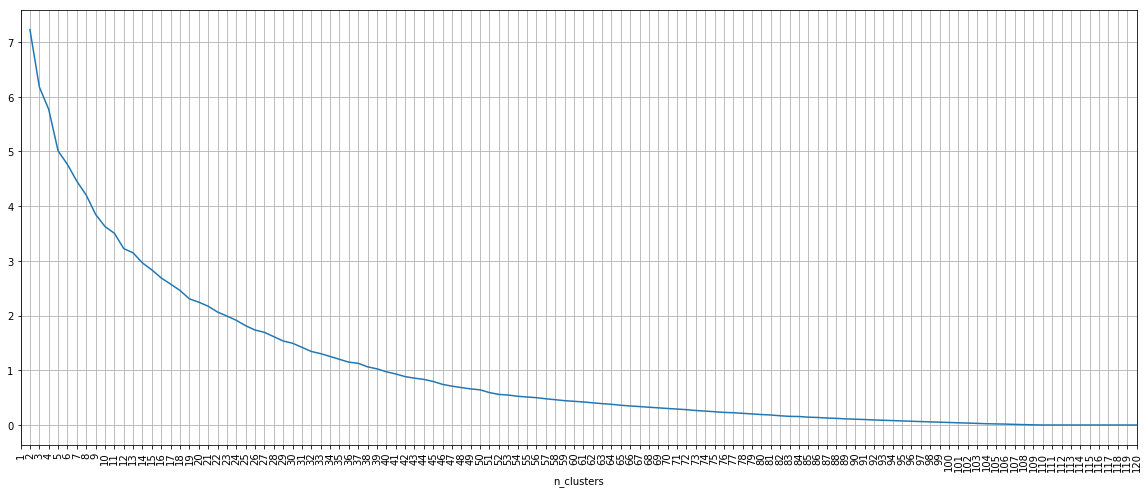

In [11]:
km_results = pd.DataFrame(results).set_index('n_clusters')
km_results['inertia'].plot(xticks=range(1, 121), 
                           figsize=(20,8), 
                           rot=90)
plt.grid(axis='both');

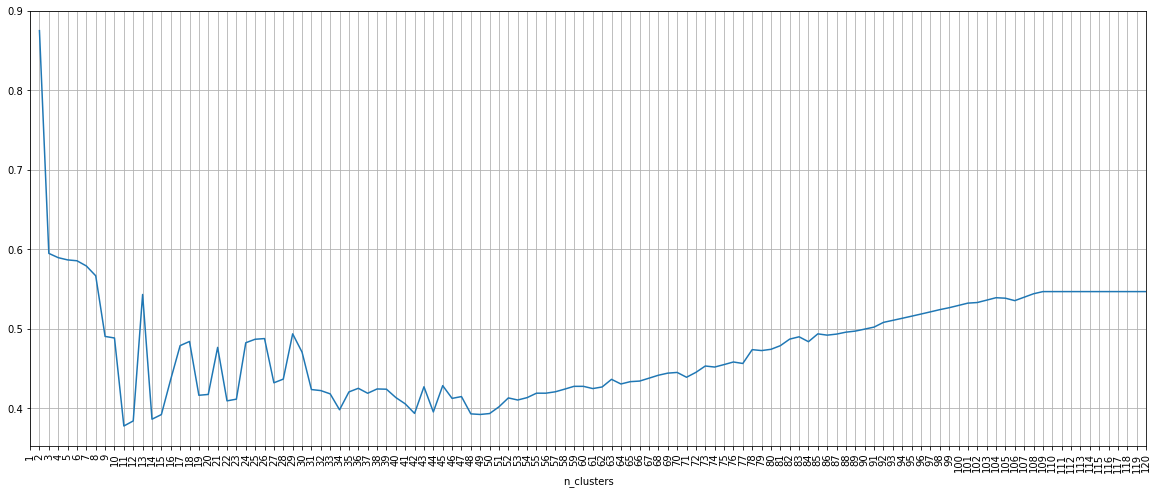

In [12]:
km_results['silhouette_score'].plot(xticks=range(1, 121), 
                                    figsize=(20,8),
                                    rot=90)
plt.grid(axis='both');

Silhouette score dips at 2 clusters, which feels like too few, and then again at 8 clusters. Inertia plot is fairly smooth, with no obvious elbow, although there's one-ish around $k=5$. So let's model with 5 clusters.

In [13]:
kclusters = 5
km_results.loc[kclusters, 'inertia':'silhouette_score']

inertia             5.00995
silhouette_score    0.58653
Name: 5, dtype: object

In [14]:
grid_categories['cluster'] = km_results.loc[kclusters].labels_ + 1

grid_section_centers = cf.calc_grid_centers(grid_size)
grid_categories['grid_section_lat'] = grid_section_centers[:, 0]
grid_categories['grid_section_long'] = grid_section_centers[:, 1]

In [15]:
grid_categories['cluster'].value_counts()

2    196
5     14
1     13
4      1
3      1
Name: cluster, dtype: int64

In [16]:
# create map
map_clusters = cf.draw_rexburg_map()

grid_squares = cf.grid_square_bounds(grid_size)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.tab10(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for (lat, lon, poi, 
    cluster, square, center) in zip(grid_categories['grid_section_lat'], 
                                   grid_categories['grid_section_long'], 
                                   grid_categories.index, 
                                   grid_categories['cluster'],
                                   grid_squares.reshape(-1, 2, 2),
                                   grid_section_centers):
    
    label = folium.Popup(f'Grid {poi}' + ' Cluster ' + str(cluster + 1))

    folium.Rectangle(
        square,
        popup=label,
        color='gray',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5,
        weight=0.5,
        ).add_to(map_clusters)

    folium.map.Marker(
        center,
        icon=DivIcon(icon_size=(0,0),
                     icon_anchor=(5,7),
                     html=f'<div style="text-align:center;font-size:8pt;'
                          f'color:#2C66AB;font-weight:bold">{cluster}</div>')
        ).add_to(map_clusters)
       
map_clusters

## Analysis & interpretation 

Let's see what attributes form and differentiate the clusters.

We'll roll up our 158 categories into the 9 category types to make them easier to visualize.

First, map `groups: types`.

In [233]:
group_type_mapping = {key: value for key, value in 
                      (rexburg_venues.groupby('group').first()[['type']]).itertuples()}
for key in list(group_type_mapping.keys())[:10]:
    print(f'{key}: {group_type_mapping[key]}')
print('...')

ATM: Shop & Service
Airport: Travel & Transport
American Restaurant: Food
Animal Shelter: Professional & Other Places
Arcade: Arts & Entertainment
Art Gallery: Arts & Entertainment
Arts & Crafts Store: Shop & Service
Asian Restaurant: Food
Assisted Living: Residence
Athletics & Sports: Outdoors & Recreation
...


Then get the categories...

In [241]:
clusters = grid_categories.groupby('cluster').sum().T
clusters.index

Index(['ATM', 'Airport', 'American Restaurant', 'Animal Shelter', 'Arcade',
       'Art Gallery', 'Arts & Crafts Store', 'Asian Restaurant',
       'Assisted Living', 'Athletics & Sports',
       ...
       'Tea Room', 'Thrift / Vintage Store', 'Trade School', 'Trail',
       'University', 'Video Game Store', 'Video Store', 'grid_section_lat',
       'grid_section_long', 'type'],
      dtype='object', length=159)

...and map the types into our clusters dataframe.

In [243]:
clusters['type'] = clusters.index
clusters['type'] = clusters['type'].map(group_type_mapping)
clusters[['type']].head()

cluster,type
ATM,Shop & Service
Airport,Travel & Transport
American Restaurant,Food
Animal Shelter,Professional & Other Places
Arcade,Arts & Entertainment


Now we roll up the clusters, counting venues by type and counting the number of grid squares in each cluster.

In [244]:
cluster_venue_types = clusters.groupby('type').sum().T
cluster_venue_types['cluster_grid_count'] = grid_categories.groupby('cluster'
                                                              ).count()['type']
cluster_venue_types

type,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,cluster_grid_count
cluster,,,,,,,,,,
1,8.0,24.0,44.0,1.0,2.0,60.0,7.0,77.0,3.0,13
2,15.0,27.0,29.0,5.0,36.0,73.0,20.0,99.0,6.0,196
3,4.0,46.0,4.0,0.0,1.0,6.0,1.0,2.0,0.0,1
4,6.0,1.0,10.0,0.0,0.0,12.0,1.0,12.0,0.0,1
5,9.0,26.0,17.0,1.0,6.0,14.0,49.0,13.0,6.0,14


We'll divide the count of venues in each category type by the total number of grid squares in the cluster to get an average number of venues per grid square by category type. This is important since we have so much variation in how many grid squares are in each cluster (in the range $[1, 196]$).

We'll use that normalized venue count to build a heatmap of venue category types by cluster to see what distinguishes the clusters one from another.

In [261]:
cluster_grid_count = np.array(cluster_venue_types['cluster_grid_count']).reshape(-1,1)

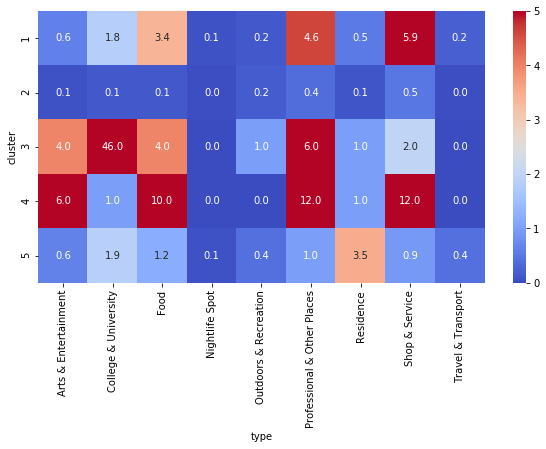

In [281]:
plt.figure(figsize=(10,5))
sns.heatmap(cluster_venue_types.iloc[:, :-1] * (1 / cluster_grid_count),
            cmap='coolwarm', vmax=5, annot=True, fmt='.1f');

In [246]:
grid_square_cluster = {key: value for key, value in 
                       grid_categories[['cluster']].itertuples()}
rexburg_venues['cluster'] = rexburg_venues['grid_section'
                                          ].map(grid_square_cluster)

Let's take a look at the top 10 venue types by cluster.

In [282]:
n=15
for cluster in range(1, kclusters + 1):
    print('-'*55)
    print(f'Top {n} Venue Category Groups for Cluster {cluster}'.center(55))
    print(f'(average venue count per grid square)'.center(55))
    print('-'*55)
    print(round(rexburg_venues[rexburg_venues['cluster'] == cluster
                        ]['group'].value_counts()[:n] / cluster_grid_count[cluster-1], 2))
    print('')

-------------------------------------------------------
       Top 15 Venue Category Groups for Cluster 1      
         (average venue count per grid square)         
-------------------------------------------------------
Office                                      1.85
Medical Center                              1.08
Mobile Phone Shop                           0.69
Building                                    0.62
College Administrative Building             0.62
Dessert Shop                                0.62
Fast Food Restaurant                        0.54
Pizza Place                                 0.54
Residential Building (Apartment / Condo)    0.54
Bank                                        0.46
Government Building                         0.46
Financial or Legal Service                  0.38
Clothing Store                              0.38
Hardware Store                              0.31
Gas Station                                 0.31
Name: group, dtype: float64

------------

Based on the heatmap and the top vanue category groups, we can give our five clusters snappy names and descriptions:

- **_Cluster 1: Business District_**
    - With offices, medical buildings, shopping, and banks, this is where you go to get stuff done.


- **_Cluster 2: The Burbs_**
    - Sparsely dotted with churches, schools, and parks, this is where people who don't care to be walking distance to campus live and play.


- **_Cluster 3: The University_**
    - All college, all the time.


- **_Cluster 4: Downtown_**
    - Arts, entertainment, food, and offices: it's the center of the bustling metropolis of Rexburg.


- **_Cluster 5: Residential Zones_**
    - With 4.5 residential buildings every 15 or so acres or so, churches, and college buildings, this is where the college kids live to keep their walk to campus short.
    
![rexburg_grid](assets/rexburg_cluster_grid.png "Grid with clusters")

----